In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')
import calendar

In [ ]:
data=pd.read_csv('My Uber Drives - 2016.csv')
data.head()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [ ]:
data.tail()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
1151,12/31/2016 13:24,12/31/2016 13:42,Business,Kar?chi,Unknown Location,3.9,Temporary Site
1152,12/31/2016 15:03,12/31/2016 15:38,Business,Unknown Location,Unknown Location,16.2,Meeting
1153,12/31/2016 21:32,12/31/2016 21:50,Business,Katunayake,Gampaha,6.4,Temporary Site
1154,12/31/2016 22:08,12/31/2016 23:51,Business,Gampaha,Ilukwatta,48.2,Temporary Site
1155,Totals,NaN,NaN,NaN,NaN,12204.7,NaN


In [ ]:
data=data[:-1]

In [ ]:
data.isnull().sum()

START_DATE*      0
END_DATE*        0
CATEGORY*        0
START*           0
STOP*            0
MILES*           0
PURPOSE*       502
dtype: int64

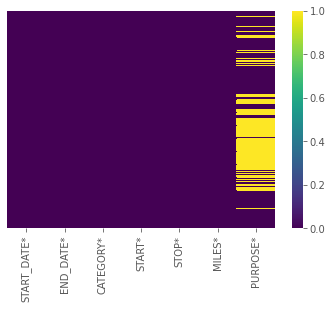

In [ ]:
sns.heatmap(data.isnull(),yticklabels=False,cmap="viridis")

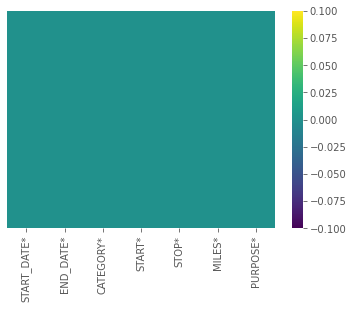

In [ ]:
data=data.dropna()
sns.heatmap(data.isnull(),yticklabels=False,cmap="viridis")

In [ ]:
data['START_DATE*'] = pd.to_datetime(data['START_DATE*'], format="%m/%d/%Y %H:%M")
data['END_DATE*'] = pd.to_datetime(data['END_DATE*'], format="%m/%d/%Y %H:%M")

In [ ]:
hour=[]
day=[]
dayofweek=[]
month=[]
weekday=[]
for x in data['START_DATE*']:
    hour.append(x.hour)
    day.append(x.day)
    dayofweek.append(x.dayofweek)
    month.append(x.month)
    weekday.append(calendar.day_name[dayofweek[-1]])
data['HOUR']=hour
data['DAY']=day
data['DAY_OF_WEEK']=dayofweek
data['MONTH']=month
data['WEEKDAY']=weekday

In [ ]:
time=[]
data['TRAVELLING_TIME']=data['END_DATE*']-data['START_DATE*']
for i in data['TRAVELLING_TIME']:
    time.append(i.seconds/60)
data['TRAVELLING_TIME']=time
data.head()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*,HOUR,DAY,DAY_OF_WEEK,MONTH,WEEKDAY,TRAVELLING_TIME
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,21,1,4,1,Friday,6.0
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,20,2,5,1,Saturday,13.0
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,17,5,1,1,Tuesday,14.0
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,14,6,2,1,Wednesday,67.0
5,2016-01-06 17:15:00,2016-01-06 17:19:00,Business,West Palm Beach,West Palm Beach,4.3,Meal/Entertain,17,6,2,1,Wednesday,4.0


In [ ]:
data['TRAVELLING_TIME']=data['TRAVELLING_TIME']/60
data['SPEED']=data['MILES*']/data['TRAVELLING_TIME']
data.head()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*,HOUR,DAY,DAY_OF_WEEK,MONTH,WEEKDAY,TRAVELLING_TIME,SPEED
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,21,1,4,1,Friday,0.100000,51.000000
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,20,2,5,1,Saturday,0.216667,22.153846
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,17,5,1,1,Tuesday,0.233333,20.142857
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,14,6,2,1,Wednesday,1.116667,57.044776
5,2016-01-06 17:15:00,2016-01-06 17:19:00,Business,West Palm Beach,West Palm Beach,4.3,Meal/Entertain,17,6,2,1,Wednesday,0.066667,64.500000


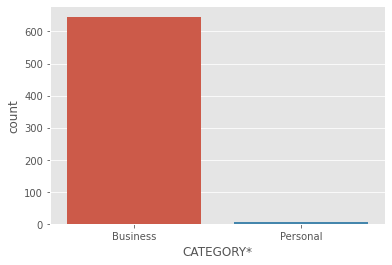

In [ ]:
sns.countplot(x='CATEGORY*',data=data)

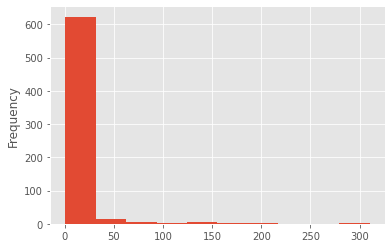

In [ ]:
data['MILES*'].plot.hist()

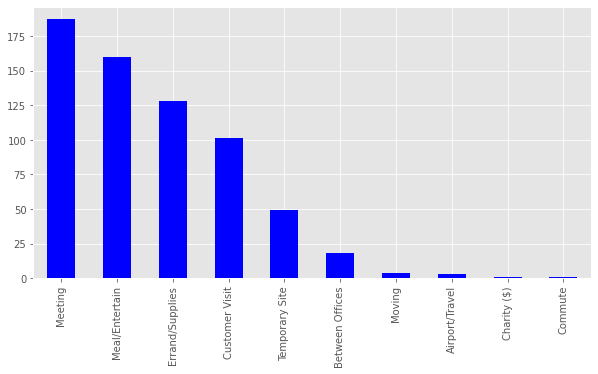

In [ ]:
data['PURPOSE*'].value_counts().plot(kind='bar',figsize=(10,5),color='blue')

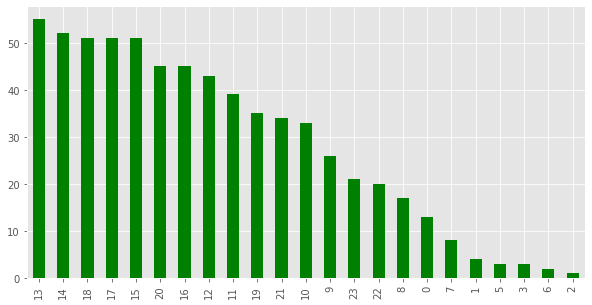

In [ ]:
data['HOUR'].value_counts().plot(kind='bar',figsize=(10,5),color='green')

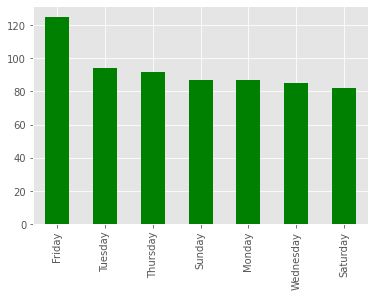

In [ ]:
data['WEEKDAY'].value_counts().plot(kind='bar',color='green')

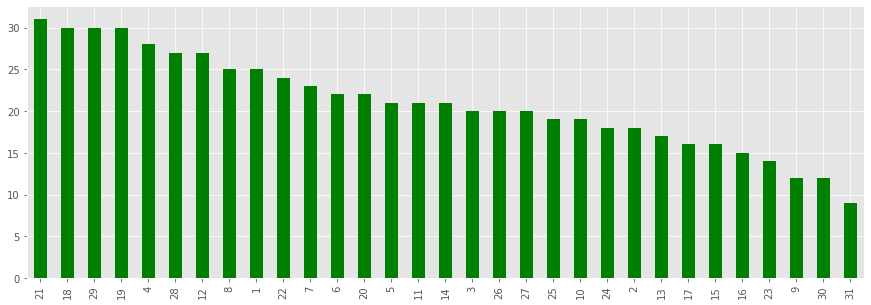

In [ ]:
data['DAY'].value_counts().plot(kind='bar',figsize=(15,5),color='green')

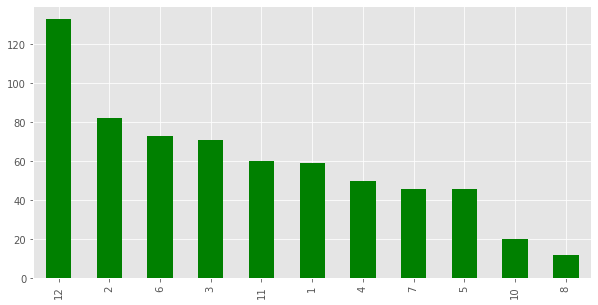

In [ ]:
data['MONTH'].value_counts().plot(kind='bar',figsize=(10,5),color='green')

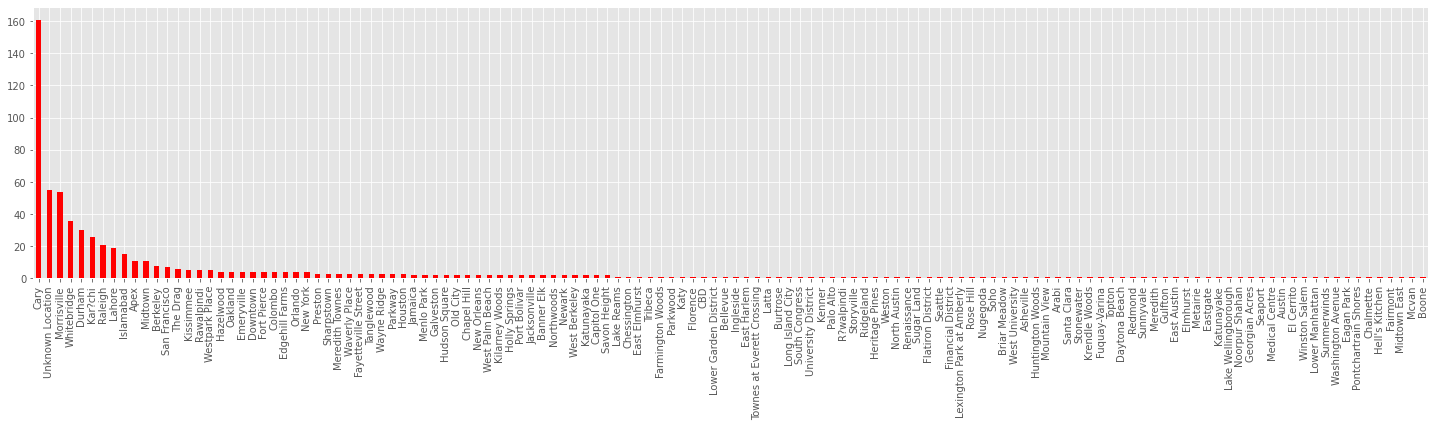

In [ ]:
data['START*'].value_counts().plot(kind='bar',figsize=(25,5),color='red')

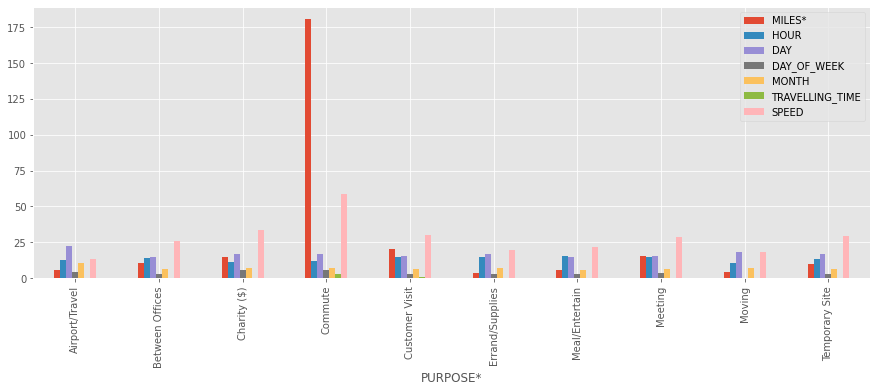

In [ ]:
data.groupby('PURPOSE*').mean().plot(kind='bar',figsize=(15,5))